### 6.합성곱 신경망

#### 6.2 AlexNet

In [1]:
# 라이브러리 로드
import torch
import torchvision
import torchvision.transforms as tr
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# CIFAR10 데이터 셋 로드
# tr.Normalize((평균), (표준편차)) -> Z점수 정규화 수행 -> (X - 평균)/표준편차
transform = tr.Compose([tr.ToTensor(), tr.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]) 
trainset = torchvision.datasets.CIFAR10(root="./data", train=True, download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=32, shuffle=True)
testset = torchvision.datasets.CIFAR10(root="./data", train=False, download=True, transform=transform)
testloader = DataLoader(testset, batch_size=32, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


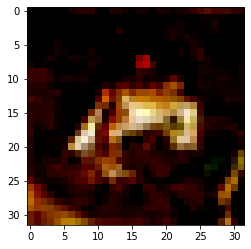

In [3]:
# 이미지 확인
img = trainset[0][0].permute(1,2,0).numpy()
plt.imshow(img)

In [4]:
# GPU 연산 체크하기
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"{device} is available.")

cuda:0 is available.


In [5]:
# 클래스 상속관한 팁
class A:
    def __init__(self):
        print("a", end='')

class B(A):
    def __init__(self):
        super(B, self).__init__()
        print("b", end='')

class C(B):
    def __init__(self):
        super(B, self).__init__() # super(클래스이름, self) => 명시된 클래스이름의 부모부터 탐색(상속) 함, 즉 super(B, self) 는 B의 부모 즉 A클래스의 속성 및 메소드를 사용한다는 의미 그래스 출력에서 b를 건너뛴 acd만 출력!
        print("c", end='')

class D(C):
    def __init__(self):
        super(D, self).__init__()
        print("d", end='')

d = D()

acd

In [6]:
# AlexNet 구축하기
class AlexNet(nn.Module):
    def __init__(self):
        super(AlexNet, self).__init__() #super().__init__()이라는 코드가 다른 클래스의 속성 및 메소드를 자동으로 불러와 해당 클래스에서도 사용이 가능
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, 3), nn.ReLU(),  # nn.Conv2d(입력채널: 3, 출력채널: 64, 필터크기: 3 ->3x3)
            nn.MaxPool2d(2,2),
            # 이전층의 출력채널 수: 64, 다음층의 입력채널 수: 64 는 맞춰줘야 함
            nn.Conv2d(64, 192, 3, padding=1), nn.ReLU(),  # padding=1 해당층의 feature 맵의 외각을 0으로 둘러쌈, ex) feature 크기 29x29 -> 31x31
            nn.MaxPool2d(2,2), # nn.MaxPool2d(필터크기: 2 -> 2x2, 보폭: 2)
            nn.Conv2d(192, 384, 3, padding=1), nn.ReLU(),
            nn.Conv2d(384, 256, 3, padding=1), nn.ReLU(),
            nn.Conv2d(256, 256, 1), nn.ReLU(),
            nn.MaxPool2d(2,2))
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(256*3*3, 1024), nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(1024, 512), nn.ReLU(),
            nn.Linear(512, 10))
    def forward(self, x):
        x = self.features(x)
        #print("conv out shape: ")
        #print(x.size())
        x = x.view(-1, 256*3*3)
        x = self.classifier(x)
        return x

In [7]:
# Conv2d() 함수의 데이터 입력력 형태 확인
input = torch.Tensor(torch.rand((3, 32, 32)))
print(input.size())
fc = nn.Conv2d(3, 64, 3, stride=1)
output = fc(input)
print(output.size())

torch.Size([3, 32, 32])
torch.Size([64, 30, 30])


In [8]:
# 손실함수 및 최적화 방법 정의
criterion = nn.CrossEntropyLoss() # 손실함수
alexNet = AlexNet().to(device)
optimizer = optim.Adam(alexNet.parameters(), lr=1e-3)

In [ ]:
# AlexNet 학습

loss_stack=[]
for i in range(25):
    minibatch_cnt = len(trainloader)
    minibatch_loss = 0.0    
    for data in trainloader:
        optimizer.zero_grad()
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = alexNet.forward(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        minibatch_loss += loss.item()

    epoch_loss = minibatch_loss/minibatch_cnt    
    loss_stack.append(epoch_loss)
    
    print(f"epoch: {i}, Loss: {epoch_loss}")

plt.plot(loss_stack)
plt.show()    

In [9]:
# 파이토치 모델 저장
PATH = "./models/cifar_alexnet.pth" # .pth 파일은 모델이 저장될 파일 (Inference:추론)을 원할 경우 *.pth파일 형식으로 저장
torch.save(alexNet.state_dict(), PATH)

In [ ]:
# 파이토치 모델 로드
alexNet2 = AlexNet().to(device)
alexNet2.load_state_dict(torch.load(PATH))

In [ ]:
# 평가하기
correct = 0
total = 0

with torch.no_grad():
    alexNet2.eval()
    for data in testloader:
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = alexNet2.forward(inputs)
        _, predicted = torch.max(outputs, 1)        
        total += labels.size(0)
        correct += (labels == predicted).sum().item()

print("Test accuracy: %.2f%%" %( (correct/total)*100 ) )

#### 6.3 ResNet

In [19]:
# Residual block 구축하기
# Residual block는 스킵 커넥션과정을 하나로 묶은 개념, 
# skip connection: 입력 값을 일련의 여러 레이어 결과 값이 더한 개념, 물론 입력 값은 레이어의 입력 값이기도 함
#     ┏------------------------------------------┓
#     |                                          V  
#  입력값 -> 레이어1 -> 레이어2 -> ... 레이어n --(+)--> 

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__() # 부모 클래스의 속성, 매서드를 현재 클래스에서 상속
        self.stride = stride
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.conv_block = nn.Sequential(
            nn.Conv2d(self.in_channels, self.out_channels, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(self.out_channels), # 학습을 빠르게 수행할 수 있는 배치 정규화 수행: 배치 정규화는 각 배치의 평균과 분산을 이용해 데이터를 정규화하는 방법
            nn.ReLU(),
            nn.Conv2d(self.out_channels, self.out_channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(self.out_channels))
        # 보폭이 1이상 및 입력채널-출력채널 차이등으로 입력값과 레이어 출력값의 형태가 달라졌을 때
        # 두 데이터의 더하기 연산이 불가능 함으로 입력값에 Conv 연산을 통해 레이어 출력값과 형태를 일치시키는 작업을 수행해줘야함
        # 일반적으로 downsample 작업이라 함
        if self.stride != 1 or self.in_channels != self.out_channels:
            self.downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, self.out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.out_channels))
    
    def forward(self, x):
        out = self.conv_block(x)
        if self.stride != 1 or self.in_channels != self.out_channels:
            x = self.downsample(x)
        out = F.relu(x+out)
        return out
        

In [11]:
# Down Sample 연산 확인
input = torch.Tensor(torch.rand((3, 32, 32)))
print(input.size())

in_ch = 3
out_ch = 64
conv2d_1 = nn.Conv2d(in_ch, out_ch, kernel_size=3, stride=2, padding=1, bias=False)
conv2d_2 = nn.Conv2d(out_ch, out_ch, kernel_size=3, stride=1, padding=1, bias=False)
conv2d_downsample = nn.Conv2d(in_ch, out_ch, kernel_size=1, stride=2, bias=False)

output = conv2d_1(input)
print(output.size())
output = conv2d_2(output)
print(output.size())
output = conv2d_downsample(input)
print(output.size())

torch.Size([3, 32, 32])
torch.Size([64, 16, 16])
torch.Size([64, 16, 16])
torch.Size([64, 16, 16])


In [21]:
class ResNet(nn.Module):
    def __init__(self, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_channels=64
        self.base = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU())
        self.layer1 = self._make_layer(64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(512, num_blocks[3], stride=2)
        # 위의 레이어를 통과하면 이미지의 크기는 4x4가되고 채널의 개수는 512가된다.
        self.gap = nn.AvgPool2d(4) # 4: 필터사이즈 <= 평균풀링을 거치면 4x4 => 1 즉 512x1 => 512개의 벡터가 됨
        self.fc = nn.Linear(512, num_classes)

    def _make_layer(self, out_channels, num_blocks, stride):
        # [stride:2]+[1]*(num_blocks:4-1) => [2,1,1,1]
        strides = [stride]+[1]*(num_blocks-1)
        layers=[]
        for stride in strides:
            block = ResidualBlock(self.in_channels, out_channels, stride)
            layers.append(block)
            self.in_channels = out_channels
        return nn.Sequential(*layers) # *컬렉션변수 => unpack 컬렉션 변수 ex) *[1,2,3] =>
    
    def forward(self, x):
        out = self.base(x)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.gap(out)        
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

In [13]:
# 리스트 연산 예제
strides = [2]+[1]*(4-1)
strides

[2, 1, 1, 1]

In [14]:
# 컬렉션 변수 언팩 예제
def fun1(*p):
    print(p)

a = [1,2,3]
fun1(*a)


(1, 2, 3)


In [44]:
# 모델 훈련 함수
def trainModel(model: nn.Module, dataloader: DataLoader, epoch=10):
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    criterion = nn.CrossEntropyLoss()
    loss_stack = []
    for i in range(epoch):
        batchloss_sum = 0.0
        batch_count = len(dataloader)
        for data in dataloader:
            optimizer.zero_grad()
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model.forward(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            batchloss_sum += loss.item()
        batchloss_avg = batchloss_sum/batch_count
        loss_stack.append(batchloss_avg)
        print(f"epoch: {i}, "+"loss: %.10f%%" %batchloss_avg)
    plt.figure(figsize=(7, 4))
    plt.xlabel("epoch")
    plt.ylabel("Loss")
    plt.plot(loss_stack)
    plt.show()

epoch: 0, loss: 1.4129978293%
epoch: 1, loss: 0.8971419324%
epoch: 2, loss: 0.6654915811%
epoch: 3, loss: 0.5143238052%
epoch: 4, loss: 0.3962408284%
epoch: 5, loss: 0.2906668923%
epoch: 6, loss: 0.2072989099%
epoch: 7, loss: 0.1440721179%
epoch: 8, loss: 0.1044215017%
epoch: 9, loss: 0.0873660851%


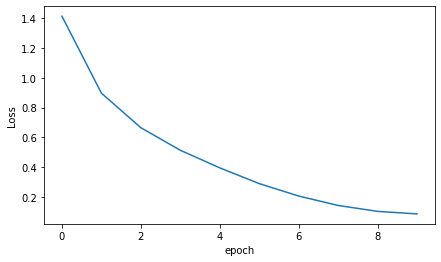

In [45]:
# 모델 훈련하기
resNet = ResNet([2,2,2,2]).to(device)
trainModel(resNet, trainloader)

In [46]:
# 파이토치 모델 저장
PATH = "./models/cifar_resnet.pth" # .pth 파일은 모델이 저장될 파일 (Inference:추론)을 원할 경우 *.pth파일 형식으로 저장
torch.save(resNet.state_dict(), PATH)